In [1]:
import numpy as np
import pandas as pd
import pickle

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
from keras import regularizers
from keras.callbacks import *

import tensorflow as tf

from dataset import atti_dirigenti

import math

import random

# to make the experimens replicable
random.seed(123456)

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/fabio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fabio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9169255106867893509, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11991931290
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11593959353260844228
 physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:0b:00.0, compute capability: 5.2"]

## Load the Dataset

In [3]:
dimension = 20000
remove_stopwords=True
skip_top=0
num_words= dimension

In [4]:
index_word_selected, (x_train, y_train), (x_val, y_val), (x_test, y_test) = atti_dirigenti.load_data(num_words=num_words, remove_stopwords=remove_stopwords)

In [5]:
label_index = atti_dirigenti.get_labels()
len(label_index)

20

In [6]:
most_common = atti_dirigenti.get_most_common_words()
word_index = atti_dirigenti.get_word_index()
stop_words = atti_dirigenti.get_stopwords()

if remove_stopwords:
    most_common = [(k,v) for k,v in most_common if k not in stop_words]

if skip_top > 0:
    most_common = most_common[skip_top:]

#take only the top k words
if num_words:
    most_common=most_common[:num_words]


most_common_selected = set([k for k,v in most_common])

index_word_selected = { word_index[w]:w for w in most_common_selected}

In [7]:
from gensim.models import KeyedVectors

In [8]:
path = '../../cc.it.300.vec/data'
fast_text_emb = KeyedVectors.load_word2vec_format(path, binary=False)

In [11]:
dimension = dimension + 200

In [12]:
embed_size = 300
embed_matrix = np.zeros((dimension, 300))
for i, word in index_word_selected.items():
    if word in fast_text_emb.vocab:
        embedding_vector = fast_text_emb.get_vector(word)
        embed_matrix[i] = embedding_vector

### Preparing Data

- for the input data we pad the sequence to a max length in order to make uniform the sequences.
- for the labels we continue with one-hot encoding


In [13]:
from keras.preprocessing import sequence

In [14]:
print('max length of objects {}'.format(max(map(len, x_train))))

max length of objects 92


#### Maximum Sequence Length

for initial test we use the first 100 words

In [15]:
maxlen = 92

In [16]:
x_train_pad = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_pad = sequence.pad_sequences(x_val, maxlen=maxlen)
x_test_pad = sequence.pad_sequences(x_test, maxlen=maxlen)

In [17]:
x_train_pad.shape

(99390, 92)

One-hot encoding for input

In [18]:
import gc
gc.collect()

0

In [94]:
def vectorize_sequences(sequences, dimension=10000):
    data = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        data[i,sequence] = 1.
    return data

In [96]:
x_train_vect = vectorize_sequences(x_train, dimension)
x_val_vect = vectorize_sequences(x_val, dimension)
x_test_vect = vectorize_sequences(x_test, dimension)

MemoryError: 

One hot encoding for the labels

In [19]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [20]:
y_train_vect = to_one_hot(y_train)
y_val_vect = to_one_hot(y_val)
y_test_vect = to_one_hot(y_test)

In [21]:
y_train_vect.shape

(99390, 20)

### Plotting Results Helpers

In [22]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 150

%matplotlib inline

In [23]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yticks(np.arange(0,2, step=0.2))
    plt.xticks(np.arange(0,len(loss), step=1))
    plt.legend()
    plt.show()

In [24]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.yticks(np.arange(0.4,1, step=0.05))
    plt.xticks(np.arange(0,len(acc), step=1))
    plt.legend()
    plt.show()

In [25]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1   

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch-1]

## Build the Models

We take into account:
- a base model that uses dropout
- an evaluation of LSTM and GRU models da uses dropout, reverse the text order and uses Bidirectional-LSTM 

In [29]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min',cooldown=0, min_lr=0),
    EarlyStopping(patience=4)
]

In [31]:
def build_model_dropout(neurons):
    with tf.device('/gpu:0'):
        model = models.Sequential()
        model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train_vect.shape[-1], )))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(neurons, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(len(label_index), activation='softmax'))

        model.compile(optimizer=optimizers.Adam(), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [32]:
model_dropout = build_model_dropout(256)
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2816256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total para

In [33]:
history_dropout = model_dropout.fit(x=x_train_vect, y=y_train_vect, validation_data=(x_val_vect, y_val_vect),
                   epochs=10, batch_size=256, callbacks=callbacks)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 10s 100us/step - loss: 1.3087 - acc: 0.5830 - val_loss: 0.6126 - val_acc: 0.7956
Epoch 2/10
99390/99390 [==============================] - 9s 92us/step - loss: 0.6340 - acc: 0.7870 - val_loss: 0.5207 - val_acc: 0.8196
Epoch 3/10
99390/99390 [==============================] - 9s 91us/step - loss: 0.4957 - acc: 0.8323 - val_loss: 0.4877 - val_acc: 0.8319
Epoch 4/10
99390/99390 [==============================] - 9s 91us/step - loss: 0.4154 - acc: 0.8603 - val_loss: 0.4781 - val_acc: 0.8363
Epoch 5/10
99390/99390 [==============================] - 9s 91us/step - loss: 0.3602 - acc: 0.8779 - val_loss: 0.4769 - val_acc: 0.8405
Epoch 6/10
99390/99390 [==============================] - 9s 91us/step - loss: 0.3154 - acc: 0.8938 - val_loss: 0.4737 - val_acc: 0.8450
Epoch 7/10
99390/99390 [==============================] - 9s 90us/step - loss: 0.2881 - acc: 0.9033 - val_loss: 0.4715 - val_a

In [34]:
embed_matrix.shape

(10500, 300)

In [26]:
def build_model_cnn():
    with tf.device('/gpu:0'):
        model = models.Sequential()
        model.add(layers.Embedding(
            input_dim=dimension, 
            output_dim=300, 
            weights=[embed_matrix],
            input_length=maxlen,
            trainable=False
        ))
        model.add(layers.Conv1D(32, 5, activation='relu'))
        model.add(layers.MaxPooling1D(3))
        model.add(layers.Conv1D(32, 5, activation='relu'))
        model.add(layers.GlobalMaxPool1D())
        model.add(layers.Dense(len(label_index), activation='softmax'))

        model.compile(optimizer=optimizers.Adam(), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [27]:
model_cnn = build_model_cnn()
model_cnn.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 92, 300)           6060000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 32)            48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 32)            5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                660       
Total params: 6,113,844
Trainable params: 53,844
Non-traina

In [35]:
history_cnn = model_cnn.fit(x=x_train_pad, y=y_train_vect,  validation_data=(x_val_pad, y_val_vect),
                   epochs=10, batch_size=32, callbacks=callbacks)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 12s 121us/step - loss: 0.5526 - acc: 0.8172 - val_loss: 0.9600 - val_acc: 0.7003
Epoch 2/10
99390/99390 [==============================] - 12s 118us/step - loss: 0.5526 - acc: 0.8172 - val_loss: 0.9600 - val_acc: 0.7003
Epoch 3/10
99390/99390 [==============================] - 12s 119us/step - loss: 0.5526 - acc: 0.8173 - val_loss: 0.9600 - val_acc: 0.7004
Epoch 4/10
99390/99390 [==============================] - 12s 120us/step - loss: 0.5525 - acc: 0.8172 - val_loss: 0.9600 - val_acc: 0.7003

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 5/10
99390/99390 [==============================] - 12s 119us/step - loss: 0.5525 - acc: 0.8173 - val_loss: 0.9600 - val_acc: 0.7003
Epoch 6/10
99390/99390 [==============================] - 12s 119us/step - loss: 0.5525 - acc: 0.8173 - val_loss: 0.9600 - val_acc: 0.7003

Epoch 00006: ReduceLROnPlateau red

In [36]:
%xdel model_cnn

In [38]:
def build_model_rnn(neurons, bidirectional=False, num_layers=1, 
                    dropout=0.0, recurrent_dropout=0.0, cell_type=layers.GRU):
    model = models.Sequential()
    model.add(layers.Embedding(
        input_dim=dimension, 
        output_dim=300, 
        weights=[embed_matrix],
        input_length=maxlen,
        trainable=False
    ))

    def create_layer(bidirectional=False, return_sequences=True):
        layer = cell_type(neurons, activation='relu',
                                 dropout= dropout,
                                 recurrent_dropout = recurrent_dropout,
                                 return_sequences=return_sequences)
        if bidirectional:
            layer = layers.Bidirectional(layer)

        return layer

    for l in range(num_layers -1):
        if l == 0:
            model.add(create_layer(bidirectional=bidirectional))
        else:
            model.add(create_layer())


    model.add(create_layer(return_sequences=False))
    model.add(layers.Dense(len(label_index), activation='softmax'))

    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [39]:
model_gru = model_gru = build_model_rnn(64, bidirectional=True, cell_type=layers.GRU, num_layers=2)
model_gru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 92, 300)           6060000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92, 128)           140160    
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 6,238,516
Trainable params: 178,516
Non-trainable params: 6,060,000
_________________________________________________________________


In [142]:
%xdel model_gru

In [44]:
history_gru = model_gru.fit(x=x_train_pad, y=y_train_vect,  validation_data=(x_val_pad, y_val_vect),
                   epochs=10, batch_size=128, callbacks=callbacks)

Train on 99390 samples, validate on 11044 samples
Epoch 1/10
99390/99390 [==============================] - 170s 2ms/step - loss: 0.4817 - acc: 0.8283 - val_loss: 0.6652 - val_acc: 0.7803
Epoch 2/10
99390/99390 [==============================] - 170s 2ms/step - loss: 0.4648 - acc: 0.8343 - val_loss: 0.6778 - val_acc: 0.7758
Epoch 3/10
99390/99390 [==============================] - 170s 2ms/step - loss: 0.4489 - acc: 0.8396 - val_loss: 0.6775 - val_acc: 0.7835
Epoch 4/10
99390/99390 [==============================] - 171s 2ms/step - loss: 0.4374 - acc: 0.8435 - val_loss: 0.6802 - val_acc: 0.7799

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/10
99390/99390 [==============================] - 171s 2ms/step - loss: 0.3735 - acc: 0.8686 - val_loss: 0.6626 - val_acc: 0.7886
Epoch 6/10
99390/99390 [==============================] - 170s 2ms/step - loss: 0.3608 - acc: 0.8732 - val_loss: 0.6764 - val_acc: 0.7867
Epoch 7/10
99390/99390 [================

### Printing The Loss

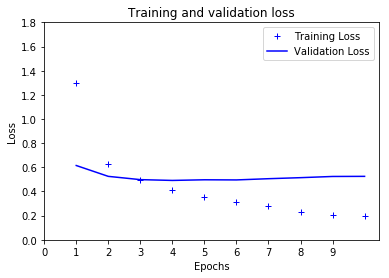

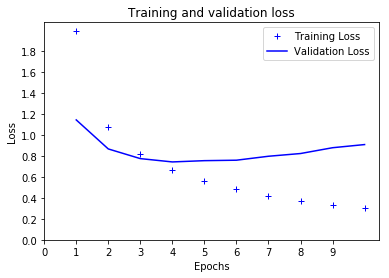

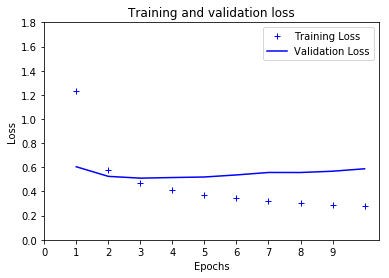

In [68]:
chart_loss(history_dropout)
chart_loss(history_cnn)
chart_loss(history_gru)

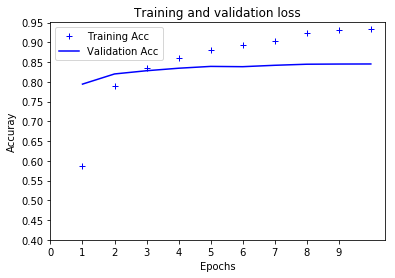

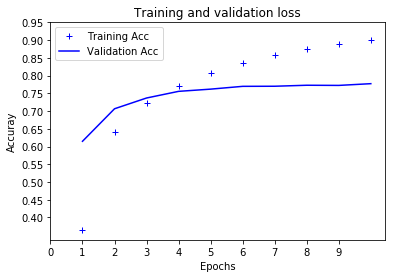

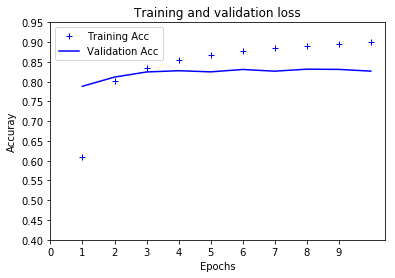

In [44]:
chart_acc(history_dropout)
chart_acc(history_cnn)
chart_acc(history_gru)

From the chart above we can see that the best model is the model that uses dropout, while the best epoch is the 6 where the validation accuracy crosses the training accuracy

In [46]:
def compare_loss(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_loss']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Validation Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

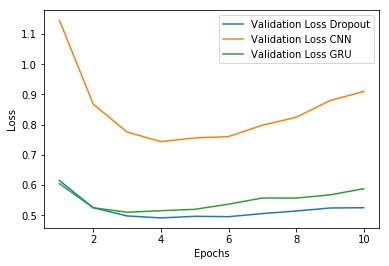

In [48]:
compare_loss({'Dropout': history_dropout, 'CNN': history_cnn, 'GRU': history_gru})

In [50]:
def compare_accuracy(histories):
    epochs = range(1, len(list(histories.values())[0].history['val_acc']) + 1)

    for i, history in histories.items():
        val_loss = history.history['val_acc']
        plt.plot(epochs, val_loss, label='Validation Accuracy {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

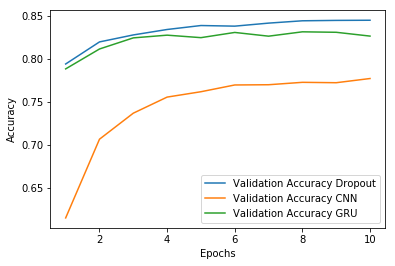

In [51]:
compare_accuracy({'Dropout': history_dropout, 'CNN': history_cnn, 'GRU': history_gru})

In [52]:
def min_loss(history):
    val_loss = history.history['val_loss'] 
    return np.argmin(val_loss) + 1 

def accuracy(history, epoch):
    val_acc = history.history['val_acc']
    return val_acc[epoch - 1]

In [54]:
print('min loss for model dropout is {}'.format(min_loss(history_dropout)))
print('min loss for model cnn is {}'.format(min_loss(history_cnn)))
print('min loss for model gru is {}'.format(min_loss(history_gru)))

min loss for model dropout is 4
min loss for model cnn is 4
min loss for model gru is 3


In [56]:
print('best validation accuracy for model dropout is {}'.format(
    accuracy(history_dropout, min_loss(history_dropout))))
print('best validation accuracy for model cnn is {}'.format(
    accuracy(history_cnn, min_loss(history_cnn))))
print('best validation accuracy for model gru is {}'.format(
    accuracy(history_gru, min_loss(history_gru))))

best validation accuracy for model dropout is 0.834299167054842
best validation accuracy for model cnn is 0.7555233611658145
best validation accuracy for model gru is 0.824520101498884


### Evaluate on the Test Set

We still want to evaluate the models with embedding to understand if it overfits on input data.

In [57]:
model = build_model_rnn(128,256, bidirectional=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 100, 128)          1408000   
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 128)          512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 512)               591360    
_________________________________________________________________
dense_10 (Dense)             (None, 20)                10260     
Total params: 2,010,132
Trainable params: 2,009,876
Non-trainable params: 256
_________________________________________________________________


In [60]:
history = model.fit(x=np.concatenate([x_train_pad, x_val_pad]), y=np.concatenate([y_train_vect, y_val_vect]), 
                    epochs=3, batch_size=256)

Epoch 1/3
110434/110434 [==============================] - 118s 1ms/step - loss: 1.2023 - acc: 0.6210
Epoch 2/3
110434/110434 [==============================] - 117s 1ms/step - loss: 0.5659 - acc: 0.8043
Epoch 3/3
110434/110434 [==============================] - 117s 1ms/step - loss: 0.4669 - acc: 0.8373


In [45]:
loss, acc = model_gru.evaluate(x_test_pad, y_test_vect)

27609/27609 [==============================] - 58s 2ms/step


In [46]:
print('loss {}'.format(loss))
print('acc {}'.format(acc))

loss 0.6795147741094365
acc 0.7895613749053418


In [68]:
from sklearn import metrics

predictions = model_gru.predict_classes(x_test_pad, batch_size=128)

In [69]:
metrics.confusion_matrix(y_test, predictions)

array([[ 506,    7,   10,    5,    4,    5,  167,    5,    6,    0,   13,
           1,   10,    0,    0,    5,    0,   22,    0,    0],
       [   3, 1464,    5,    0,   24,  155,   17,   36,    4,    0,    4,
           1,   13,    6,    1,   35,  156,   10,    0,   11],
       [  11,    8,  456,    3,    8,   10,    8,   10,    9,    0,   16,
           0,    9,    0,    0,  107,   11,    1,    2,    0],
       [   2,    2,    8,  364,    3,    9,    1,    5,    2,    0,    5,
           2,  198,    3,    0,    0,    0,    1,    0,    1],
       [   2,   28,    6,    3, 1282,    5,   29,   45,    4,    2,   57,
           6,   50,   24,   16,   30,   51,   18,    0,    0],
       [   7,  173,   24,    9,    8,  650,    3,   13,   22,    0,   17,
           3,   11,    6,    0,    8,   19,    0,    0,   12],
       [ 137,   12,   12,    0,   22,    8, 1025,   12,    5,    0,    5,
           1,   17,    3,    0,   18,    4,  214,    0,    1],
       [   3,   26,    5,    6,   44,   1

In [85]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [86]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization


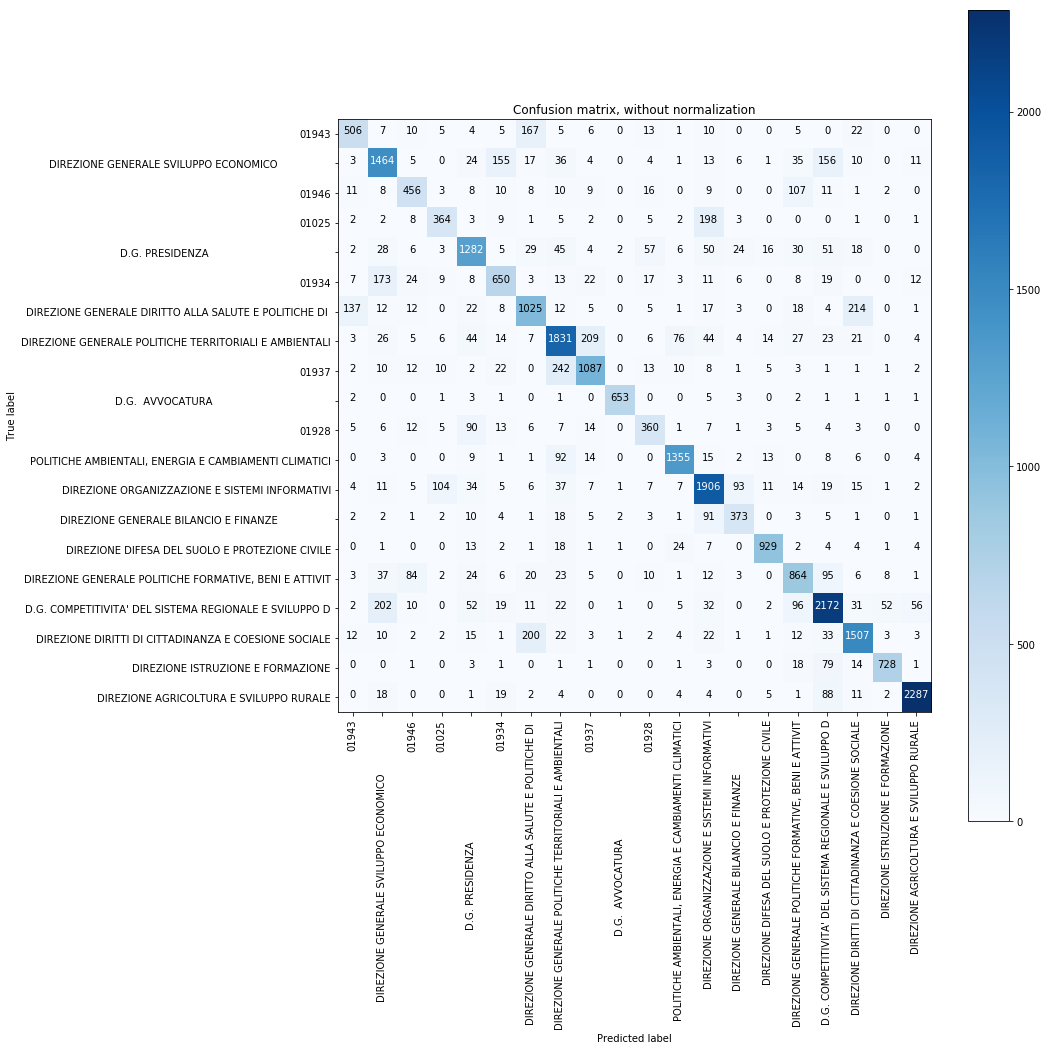

In [87]:
# plt.figure()
plt.rcParams['figure.figsize'] = (15,15)
plot_confusion_matrix(metrics.confusion_matrix(y_test, predictions), classes=label_index,
                      title='Confusion matrix, without normalization')

In [71]:
from sklearn.metrics import precision_recall_fscore_support

In [73]:
precision_recall_fscore_support(y_test, predictions, average='weighted')

(0.7902249197162654, 0.7895613749139774, 0.7895567496492675, None)

## Conclusion

We evaluated how to use Embeddings as alternative to one-hot encoding. 
